In [1]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

2.1.0+cu121


In [2]:
%%capture
# Download the corresponding PyTorch Geometric module
"""
Assign to TORCH with what you get from the cell above. E.g., export TORCH=1.12.1+cu113
"""
%env TORCH=2.1.0+cu121
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

In [3]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import Sequential, GCNConv, global_mean_pool
import networkx as nx
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
rng = np.random.default_rng()

cuda


In [4]:
from typing import Callable, Optional, Union

import torch
from torch import Tensor

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import reset
from torch_geometric.typing import (
    Adj,
    OptPairTensor,
    OptTensor,
    Size,
    SparseTensor,
)
from torch_geometric.utils import spmm

class GINConv(MessagePassing):
  def __init__(self, nn_final: Callable, nn_intermediate_self: Callable, nn_intermediate_sum: Callable, eps: float = 0., train_eps: bool = False,
                 **kwargs):
        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)
        self.nn_final = nn_final
        self.nn_intermediate_self = nn_intermediate_self
        self.nn_intermediate_sum = nn_intermediate_sum
        self.initial_eps = eps
        if train_eps:
            self.eps = torch.nn.Parameter(torch.empty(1))
        else:
            self.register_buffer('eps', torch.empty(1))
        self.reset_parameters()

  def reset_parameters(self):
        super().reset_parameters()
        reset(self.nn_final)
        reset(self.nn_intermediate_self)
        reset(self.nn_intermediate_sum)
        self.eps.data.fill_(self.initial_eps)


  def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                size: Size = None) -> Tensor:

        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        # propagate_type: (x: OptPairTensor)
        out = self.propagate(edge_index, x=x, size=size)

        x_r = x[1]
        if x_r is not None:
            out = out + (1 + self.eps) * self.nn_intermediate_self(x_r)

        return self.nn_final(out)


  def message(self, x_j: Tensor) -> Tensor:
      return self.nn_intermediate_sum(x_j)

class OtherConv(MessagePassing):
  def __init__(self, nn_final: Callable, nn_intermediate_self: Callable, nn_intermediate_sum: Callable, eps: float = 0., train_eps: bool = False,
                 **kwargs):
        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)
        self.nn_final = nn_final
        self.nn_intermediate_self = nn_intermediate_self
        self.nn_intermediate_sum = nn_intermediate_sum
        self.initial_eps = eps
        if train_eps:
            self.eps = torch.nn.Parameter(torch.empty(1))
        else:
            self.register_buffer('eps', torch.empty(1))
        self.reset_parameters()

  def reset_parameters(self):
        super().reset_parameters()
        reset(self.nn_final)
        reset(self.nn_intermediate_self)
        reset(self.nn_intermediate_sum)
        self.eps.data.fill_(self.initial_eps)


  def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                size: Size = None) -> Tensor:

        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        # propagate_type: (x: OptPairTensor)
        out = self.propagate(edge_index, x=x, size=size)

        x_r = x[1]
        if x_r is not None:
            out = self.nn_intermediate_sum(out) + (1 + self.eps) * self.nn_intermediate_self(x_r)

        return self.nn_final(out)


  def message(self, x_j: Tensor) -> Tensor:
      return x_j




In [5]:
class GINLayer(nn.Module):
  def __init__(self, input_dim, intermediate_dim, output_dim, final_mlp_structure, intermediate_self_mlp_structure, intermediate_sum_mlp_structure, activation=nn.ReLU()):
    super().__init__()
    self.input_dim = input_dim
    self.intermediate_dim = intermediate_dim
    self.output_dim = output_dim

    self.intermediate_self_mlp = self.generate_mlp(intermediate_self_mlp_structure,input_dim,intermediate_dim,activation)
    self.intermediate_sum_mlp = self.generate_mlp(intermediate_sum_mlp_structure,input_dim,intermediate_dim,activation)
    self.final_mlp = self.generate_mlp(final_mlp_structure,intermediate_dim,output_dim,activation)

    self.gin_conv = GINConv(self.final_mlp, self.intermediate_self_mlp, self.intermediate_sum_mlp)

  def generate_mlp(self, sequence, input_dim, output_dim, activation):
    mlp = [nn.Linear(input_dim, sequence[0], bias=False), activation]
    for i in range(len(sequence)-1):
      mlp.append(nn.Linear(sequence[i], sequence[i+1], bias=False))
      mlp.append(activation)
    mlp.append(nn.Linear(sequence[-1], output_dim, bias=False))
    return nn.Sequential(*mlp)

  def forward(self, x, adj):
    return self.gin_conv(x, adj)

class OtherLayer(nn.Module):
  def __init__(self, input_dim, intermediate_dim, output_dim, final_mlp_structure, intermediate_self_mlp_structure, intermediate_sum_mlp_structure, activation=nn.ReLU()):
    super().__init__()
    self.input_dim = input_dim
    self.intermediate_dim = intermediate_dim
    self.output_dim = output_dim

    self.intermediate_self_mlp = self.generate_mlp(intermediate_self_mlp_structure,input_dim,intermediate_dim,activation)
    self.intermediate_sum_mlp = self.generate_mlp(intermediate_sum_mlp_structure,input_dim,intermediate_dim,activation)
    self.final_mlp = self.generate_mlp(final_mlp_structure,intermediate_dim,output_dim,activation)

    self.gin_conv = OtherConv(self.final_mlp, self.intermediate_self_mlp, self.intermediate_sum_mlp)

  def generate_mlp(self, sequence, input_dim, output_dim, activation):
    mlp = [nn.Linear(input_dim, sequence[0], bias=False), activation]
    for i in range(len(sequence)-1):
      mlp.append(nn.Linear(sequence[i], sequence[i+1], bias=False))
      mlp.append(activation)
    mlp.append(nn.Linear(sequence[-1], output_dim, bias=False))
    return nn.Sequential(*mlp)

  def forward(self, x, adj):
    return self.gin_conv(x, adj)


In [6]:
def train_epoch(dataloader, model, loss_fn, optimiser):
    """Do one epoch-worth of training."""

    # Put the model in training mode
    model.train()

    # The number of datapoints
    size = len(dataloader.dataset)

    # Loop over each batch of datapoints
    for graph_type in dataloader:
        #print(graph_type)
        # Set all the gradients to zero
        optimiser.zero_grad()
        preds = []
        for graph in graph_type:
          graph = graph.to(device)
          # Make a prediction using the current parameters
          preds.append(model(graph.x.to(torch.float), graph.edge_index))
        #print("pred", pred)
        # Compute the loss for this prediction
        loss = loss_fn(preds)
        print("loss", loss.detach().cpu().item())
        #print("data.y", data.y)

        # Propagate the loss backwards to compute the gradients
        loss.backward()

        # Do one step of optimisation
        optimiser.step()

def train(train_dataloader, test_dataloader, model, loss_fn, optimiser,
          epochs=200, output_every=10):
    """Train a model for a certain number of epochs."""
    results_flag = True
    # Loop through the epochs
    for t in range(1, epochs+1):

        # Do the training for this epoch
        train_epoch(train_dataloader, model, loss_fn, optimiser)

        # Output the accuracy of the model every so often

        if output_every is not None and t % output_every == 0:
            results = test(train_dataloader, model)
            if results_flag:
              best_results = [0]*len(results)
              results_flag = False

            no_graphs = [result[0] for result in results]
            no_distinguished_list = [result[1] for result in results]
            best_results = [max(best_result, no_distinguished) for (best_result, no_distinguished) in zip(best_results, no_distinguished_list)]
            best_restults_percentages = [100*best_result/no_graph for (best_result, no_graph) in zip(best_results, no_graphs)]
            print(f"Epoch {t}")
            print("----------------------------")
            print("Accuracy: ", results)
            print("Best results: ", best_results)
            print("Best percentages: ", best_restults_percentages)
            print()

def test(dataloader, model):
    """Test a model on some data."""

    # Put the model in evaluation mode
    model.eval()

    # Get the number of datapoints
    size = len(dataloader.dataset)

    # The number of correct predictions
    correct = 0

    # We don't want to be computing the gradients
    with torch.no_grad():
        results = []
        # Loop through the minibatches
        for graph_type in dataloader:
          preds = []
          for graph in graph_type:
            graph = graph.to(device)
            # Compute the model predictions
            preds.append(model(graph.x.to(torch.float), graph.edge_index))
          #print(preds)
          graph_no = len(preds)
          preds = torch.stack(preds)
          preds = (preds*10000).round() / 10000
          #print(preds)
          #print(torch.unique(preds, dim=0, return_counts=True))
          distinct_no = len(torch.unique(preds, dim=0, return_counts=True)[1])
          results.append((graph_no, distinct_no, graph_no - distinct_no))

    # Compute the accuracy for the whole dataset and return it
    return results

In [7]:
def criterion(embeddings):
  counter = 0
  cumulative_loss = 0.0
  no_graphs = len(embeddings)
  for i in range(no_graphs):
    for j in range(i):
      cumulative_loss += nn.functional.cosine_embedding_loss(embeddings[i], embeddings[j] + 0.01*torch.randn_like(embeddings[j]), torch.tensor(-1))
      counter += 1

  return cumulative_loss / counter

In [10]:
def label_graphs(graph, no_feature_dicts, no_colour_1, no_colour_2, no_colour_3):
  features = [1 for _ in range(no_colour_1)] + [2 for _ in range(no_colour_2)] + [3 for _ in range(no_colour_3)]
  feature_dicts = []
  for i in range(no_feature_dicts):
    random.shuffle(features)
    feature_dict = {i:item for (i,item) in enumerate(features)}
    feature_dicts.append(feature_dict)

  structurally_isomorphic_graphs = []

  for feature_dict in feature_dicts:
    temp_graph = graph.copy()
    nx.set_node_attributes(temp_graph, feature_dict, name="colour")
    structurally_isomorphic_graphs.append(temp_graph)

  hashes = []
  distinguishable_graphs = []
  for iso_graph in structurally_isomorphic_graphs:
    hash = nx.weisfeiler_lehman_graph_hash(iso_graph,  node_attr="colour", iterations=3, digest_size=16)
    if not(hash in hashes):
      distinguishable_graphs.append(from_networkx(iso_graph, group_node_attrs=["colour"]))
    hashes.append(hash)
  print("number of distinguishable graphs: ", len(distinguishable_graphs))
  return (distinguishable_graphs, len(distinguishable_graphs))


In [14]:
dataset = []
total_graphs = 0
for i in range(10):
  graphs, no_graphs = label_graphs(nx.dense_gnm_random_graph(6,7, seed=i),200,2,2,2)
  dataset.append(graphs)
  total_graphs += no_graphs

print("total number of graphs: ", total_graphs)

number of distinguishable graphs:  24
number of distinguishable graphs:  48
number of distinguishable graphs:  27
number of distinguishable graphs:  17
number of distinguishable graphs:  33
number of distinguishable graphs:  84
number of distinguishable graphs:  51
number of distinguishable graphs:  30
number of distinguishable graphs:  83
number of distinguishable graphs:  45
total number of graphs:  442


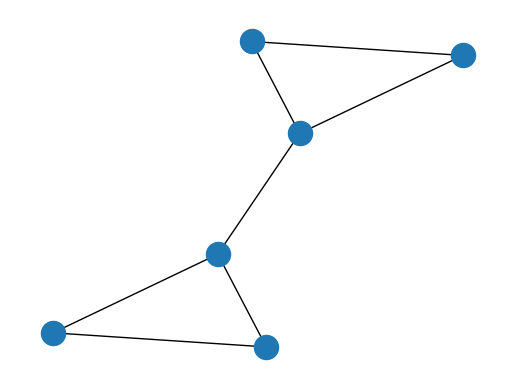

In [27]:
graph = nx.dense_gnm_random_graph(6,7, seed=3).copy()
### DO NOT MODIFY

# Display a random pair
fig, axs = plt.subplots(1, 1)
#graph = random.choice(graphs)

nx.draw(graph)

plt.show()



In [17]:

class GINConv_model(nn.Module):
  def __init__(self):
    super().__init__()

    self.gin_1 = GINLayer(input_dim=1, intermediate_dim=12, output_dim=1, final_mlp_structure=[5,8], intermediate_self_mlp_structure=[5,8] , intermediate_sum_mlp_structure=[5,8])
    self.gin_2 = GINLayer(input_dim=1, intermediate_dim=16, output_dim=1, final_mlp_structure=[8,8], intermediate_self_mlp_structure=[8,8], intermediate_sum_mlp_structure=[8,8])
    self.gin_3 = GINLayer(input_dim=1, intermediate_dim=32, output_dim=1, final_mlp_structure=[8,12], intermediate_self_mlp_structure=[8,12], intermediate_sum_mlp_structure=[8,12])

    #self.output_mlp = nn.Sequential(*[nn.Linear(3,12), nn.ReLU(), nn.Linear(12,12), nn.ReLU(), nn.Linear(12,12)])

  def forward(self, x, adj):
    h1 = self.gin_1(x, adj)
    h2 = self.gin_2(h1, adj)
    h3 = self.gin_3(h2, adj)
    #print(h3.size())
    concat = torch.cat([h1,h2,h3], axis=1)
    summed = torch.sum(concat, axis=0)
    #print(concat.size())
    #print(summed.size())
    #return self.output_mlp(summed)
    return summed


In [18]:
class OtherConv_model(nn.Module):
  def __init__(self):
    super().__init__()
    self.other_1 = OtherLayer(input_dim=1, intermediate_dim=12, output_dim=1, final_mlp_structure=[5,8], intermediate_self_mlp_structure=[5,8] , intermediate_sum_mlp_structure=[5,8])
    self.other_2 = OtherLayer(input_dim=1, intermediate_dim=16, output_dim=1, final_mlp_structure=[8,8], intermediate_self_mlp_structure=[8,8], intermediate_sum_mlp_structure=[8,8])
    self.other_3 = OtherLayer(input_dim=1, intermediate_dim=32, output_dim=1, final_mlp_structure=[8,12], intermediate_self_mlp_structure=[8,12], intermediate_sum_mlp_structure=[8,12])

    #self.output_mlp = nn.Sequential(*[nn.Linear(1,12), nn.ReLU(), nn.Linear(12,12), nn.ReLU(), nn.Linear(12,12)])

  def forward(self, x, adj):
    h1 = self.other_1(x, adj)
    h2 = self.other_2(h1, adj)
    h3 = self.other_3(h2, adj)
    #print(h3.size())
    concat = torch.cat([h1,h2,h3], axis=1)
    summed = torch.sum(concat, axis=0)
    #print(concat.size())
    #print(summed.size())
    #return self.output_mlp(summed)
    return summed


In [19]:
model = OtherConv_model().to(device)

In [ ]:
train_dataset = dataset
train_dataloader = DataLoader(train_dataset, 1)
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001)
train(train_dataloader, train_dataloader, model, criterion, optimiser, output_every=1)